In [ ]:
%load_ext autoreload
%autoreload 2

In [7]:
import os
import pathlib
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import re
import shutil
import pandas as pd
import scipy.stats
from functools import reduce
import statsmodels
import seaborn as sns
import exdir
import expipe
from distutils.dir_util import copy_tree
import septum_mec
import spatial_maps as sp
import head_direction.head as head
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
from septum_mec.analysis.plotting import violinplot, savefig, despine
from tqdm.notebook import tqdm
tqdm.pandas()

from septum_mec.analysis.statistics import (
    load_data_frames, 
    make_paired_tables, 
    make_statistics_table, 
    estimate_power_lmm, 
    estimate_power_lmm_paralell, 
    LMM, 
    estimate_sample_size_lmm, 
    estimate_sample_size_lmm_paralell
)

In [ ]:
project_path = dp.project_path()
project = expipe.get_project(project_path)
actions = project.actions

output_path = pathlib.Path("output") / "comparisons-power"
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)
(output_path / "data").mkdir(exist_ok=True, parents=True)

# Load cell statistics and shuffling quantiles

In [4]:
data, labels, colors, queries = load_data_frames()

Number of sessions above threshold 194
Number of animals 4
Number of individual gridcells 139
Number of gridcell recordings 230


# Calculate statistics

In [5]:
columns = [
    'average_rate', 
    'gridness', 
    'information_specificity',
    'max_rate', 
    'information_rate', 
    'in_field_mean_rate', 
    'out_field_mean_rate', 
    'speed_score', 
    'spacing', 
    'field_area'

]

In [6]:
results, labels = make_paired_tables(data, columns)

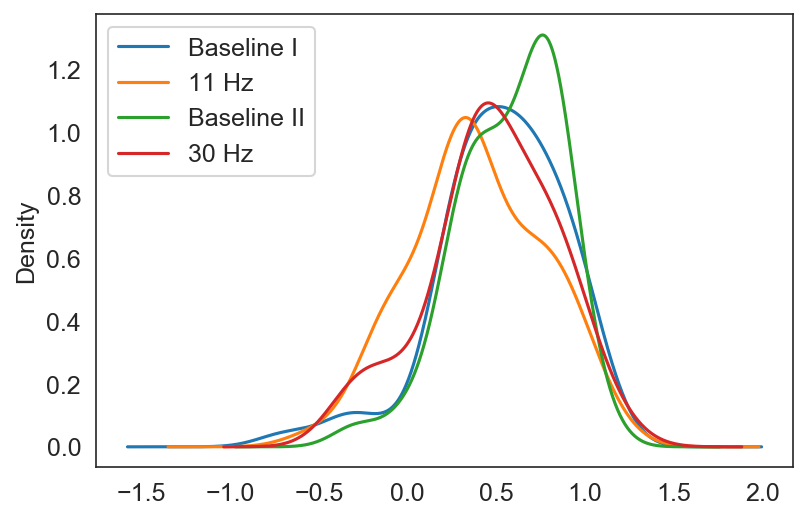

In [151]:
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (6, 4), 
    'figure.dpi': 150
})

results['gridcell']['gridness'][labels].plot.density()

In [77]:
summary = pd.DataFrame()
for key, df in results['gridcell'].items():
    Key = key.replace('_', ' ').capitalize()
    for label in labels:
        summary.loc[label, Key] = "{:.3f} ± {:.3f}".format(df[label].mean(), df[label].std())
summary.T

Baseline I            11 Hz      Baseline II  \
Average rate               9.040 ± 6.369    8.934 ± 6.545    8.368 ± 6.154   
Gridness                   0.527 ± 0.353    0.393 ± 0.369    0.579 ± 0.287   
Information specificity    0.245 ± 0.229    0.208 ± 0.264    0.218 ± 0.177   
Max rate                 37.533 ± 15.081  32.799 ± 14.292  37.684 ± 16.860   
Information rate           1.324 ± 0.617    0.906 ± 0.543    1.177 ± 0.640   
In field mean rate        14.973 ± 8.381   13.344 ± 8.073   14.126 ± 7.835   
Out field mean rate        6.389 ± 5.358    6.712 ± 5.898    5.787 ± 5.225   
Speed score                0.142 ± 0.081    0.105 ± 0.090    0.120 ± 0.060   
Spacing                    0.439 ± 0.121    0.456 ± 0.123    0.416 ± 0.093   
Field area                 0.431 ± 0.053    0.417 ± 0.051    0.423 ± 0.051   

                                   30 Hz  
Average rate               7.553 ± 5.359  
Gridness                   0.479 ± 0.355  
Information specificity    0.226 ± 0.209  
Max rate                 34.584 ± 12.544  
Information rate           0.983 ± 0.555  
In field mean rate        12.109 ± 6.060  
Out field mean rate        5.265 ± 4.488  
Speed score                0.104 ± 0.073  
Spacing                    0.424 ± 0.080  
Field area                 0.431 ± 0.052

In [83]:
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM   Dependent Variable:   val     
No. Observations:   119       Method:               REML    
No. Groups:         4         Scale:                0.0932  
Min. group size:    7         Log-Likelihood:       -49.4026
Max. group size:    81        Converged:            Yes     
Mean group size:    29.8                                    
------------------------------------------------------------
                    Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept           0.409    0.048 8.488 0.000  0.315  0.504
label[T.Baseline I] 0.124    0.062 1.997 0.046  0.002  0.246
unit_idnum Var      0.036    0.090                          
============================================================

"""

In [10]:
vss = [
    ('Baseline I', '11 Hz'),
    ('Baseline I', 'Baseline II'),
    ('Baseline II', '30 Hz'),
]

In [92]:

ps = pd.DataFrame()
ci = pd.DataFrame()
ef = pd.DataFrame()
mf = pd.DataFrame()
for key, df in results['gridcell'].items():
    Key = key.replace('_', ' ').capitalize()
    for vs in vss:
        pval, low, high, mdf = LMM(df, *vs, key)
        ps.loc[f'LMM {vs[0]} - {vs[1]}', key] = pval
        ci.loc[f'LMM {vs[0]} - {vs[1]}', key] = f'{low}, {high}'
        ef.loc[f'LMM {vs[0]} - {vs[1]}', key] = mdf.params[1]
        mf.loc[f'LMM {vs[0]} - {vs[1]}', key] = abs(df[vs[0]].mean() - df[vs[1]].mean())

In [93]:
ps

average_rate  gridness  information_specificity  \
LMM Baseline I - 11 Hz            0.928209  0.054459                 0.427792   
LMM Baseline I - Baseline II      0.626481  0.587566                 0.618199   
LMM Baseline II - 30 Hz           0.556933  0.107195                 0.839598   

                              max_rate  information_rate  in_field_mean_rate  \
LMM Baseline I - 11 Hz        0.088252          0.000080            0.285853   
LMM Baseline I - Baseline II  0.955198          0.265741            0.595705   
LMM Baseline II - 30 Hz       0.315473          0.081515            0.195477   

                              out_field_mean_rate  speed_score   spacing  \
LMM Baseline I - 11 Hz                   0.759764     0.016639  0.441497   
LMM Baseline I - Baseline II             0.642428     0.040733  0.985474   
LMM Baseline II - 30 Hz                  0.665571     0.382314  0.603904   

                              field_area  
LMM Baseline I - 11 Hz          0.112510  
LMM Baseline I - Baseline II    0.535198  
LMM Baseline II - 30 Hz         0.729193

In [94]:
ci

average_rate  \
LMM Baseline I - 11 Hz          -2.180247281054466, 2.390356722874524   
LMM Baseline I - Baseline II  -2.9916621645393118, 1.8014641972655332   
LMM Baseline II - 30 Hz        -1.6613041417405623, 3.083251607547346   

                                                                 gridness  \
LMM Baseline I - 11 Hz        -0.0023867695467641864, 0.25185586146463945   
LMM Baseline I - Baseline II    -0.08520533103529787, 0.15040363600350248   
LMM Baseline II - 30 Hz          -0.02440548847993497, 0.2496890970945263   

                                                 information_specificity  \
LMM Baseline I - 11 Hz        -0.051885367585011555, 0.12239826383625366   
LMM Baseline I - Baseline II   -0.09750576854071875, 0.05796956577487157   
LMM Baseline II - 30 Hz        -0.06538802363578307, 0.08044872106578226   

                                                            max_rate  \
LMM Baseline I - 11 Hz        -0.6829644446775598, 9.804487199879677   
LMM Baseline I - Baseline II    -5.89536982035741, 6.243311205778393   
LMM Baseline II - 30 Hz        -3.155261296686419, 9.780244204335176   

                                                       information_rate  \
LMM Baseline I - 11 Hz          0.19919191566537162, 0.5924315270050661   
LMM Baseline I - Baseline II  -0.33674475640623824, 0.09282359337229243   
LMM Baseline II - 30 Hz       -0.02805504733315664, 0.47641353819177146   

                                                  in_field_mean_rate  \
LMM Baseline I - 11 Hz         -1.331724110761481, 4.516001132500179   
LMM Baseline I - Baseline II  -3.975512425442468, 2.2816253105581294   
LMM Baseline II - 30 Hz       -1.0103474044666294, 4.941540621504646   

                                                  out_field_mean_rate  \
LMM Baseline I - 11 Hz        -2.2810214616259765, 1.6653183103649472   
LMM Baseline I - Baseline II    -2.481648525103001, 1.531057021714961   
LMM Baseline II - 30 Hz        -1.5577059549335808, 2.439136826914514   

                                                               speed_score  \
LMM Baseline I - 11 Hz            0.006403510267647752, 0.0641586683092662   
LMM Baseline I - Baseline II  -0.05295935481734079, -0.0011404936657067148   
LMM Baseline II - 30 Hz         -0.015556136704263908, 0.04057715367485169   

                                                                 spacing  \
LMM Baseline I - 11 Hz        -0.03396312071531312, 0.014810117866574444   
LMM Baseline I - Baseline II  -0.01536441943997291, 0.015081590471976884   
LMM Baseline II - 30 Hz       -0.01107815629347443, 0.019054030954896606   

                                                               field_area  
LMM Baseline I - 11 Hz        -0.0034073546240015826, 0.03240571021475902  
LMM Baseline I - Baseline II  -0.025402212987792654, 0.013191871767799448  
LMM Baseline II - 30 Hz       -0.023819756067117653, 0.016668142405318446

In [95]:
ef

average_rate  gridness  information_specificity  \
LMM Baseline I - 11 Hz            0.105055  0.124735                 0.035256   
LMM Baseline I - Baseline II     -0.595099  0.032599                -0.019768   
LMM Baseline II - 30 Hz           0.710974  0.112642                 0.007530   

                              max_rate  information_rate  in_field_mean_rate  \
LMM Baseline I - 11 Hz        4.560761          0.395812            1.592139   
LMM Baseline I - Baseline II  0.173971         -0.121961           -0.846944   
LMM Baseline II - 30 Hz       3.312491          0.224179            1.965597   

                              out_field_mean_rate  speed_score   spacing  \
LMM Baseline I - 11 Hz                  -0.307852     0.035281 -0.009577   
LMM Baseline I - Baseline II            -0.475296    -0.027050 -0.000141   
LMM Baseline II - 30 Hz                  0.440715     0.012511  0.003988   

                              field_area  
LMM Baseline I - 11 Hz          0.014499  
LMM Baseline I - Baseline II   -0.006105  
LMM Baseline II - 30 Hz        -0.003576

In [96]:
mf

average_rate  gridness  information_specificity  \
LMM Baseline I - 11 Hz            0.105449  0.133233                 0.036166   
LMM Baseline I - Baseline II      0.671719  0.052668                 0.026500   
LMM Baseline II - 30 Hz           0.814797  0.100659                 0.007509   

                              max_rate  information_rate  in_field_mean_rate  \
LMM Baseline I - 11 Hz        4.734064          0.417936            1.629185   
LMM Baseline I - Baseline II  0.151797          0.147302            0.847032   
LMM Baseline II - 30 Hz       3.100584          0.193361            2.016844   

                              out_field_mean_rate  speed_score   spacing  \
LMM Baseline I - 11 Hz                   0.322805     0.037336  0.016343   
LMM Baseline I - Baseline II             0.602720     0.021480  0.023525   
LMM Baseline II - 30 Hz                  0.521574     0.016176  0.007847   

                              field_area  
LMM Baseline I - 11 Hz          0.014129  
LMM Baseline I - Baseline II    0.008499  
LMM Baseline II - 30 Hz         0.008441

In [110]:
effect_ranges = {
    'gridness': (.01, .3, .01),
    'average_rate': (.5, 6, .2), 
    'information_specificity': (.01,.2,.01),
    'max_rate': (1,15,.5), 
    'information_rate': (.1,.4,.02), 
    'in_field_mean_rate': (.5, 6, .2), 
    'out_field_mean_rate': (.5, 6, .2), 
    'speed_score': (.01,.1,.005), # if run again, change this to go to 0.1
    'spacing': (.01,.1,.005), # if run again, change this to go to 0.1
    'field_area': (.01,.1,.005),# if run again, change this to go to 0.1
}

In [128]:
powers = {}
for vs in vss:
    powers[vs] = {}
    for key, df in tqdm(results['gridcell'].items(), desc=' - '.join(vs)):
        power, effect_size = estimate_power_lmm_paralell(results['gridcell'][key], *vs, effect_range=effect_ranges[key])
        powers[vs][key] = {'p': power, 'e': effect_size}

In [129]:
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (3.7, 2.2), 
    'figure.dpi': 150
})

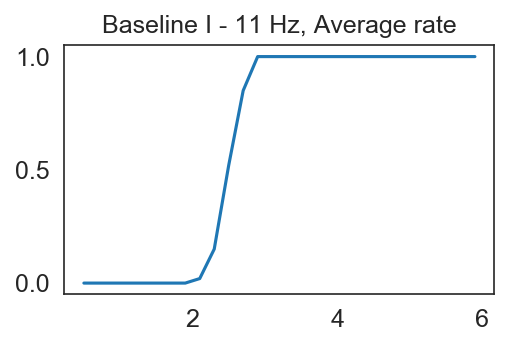

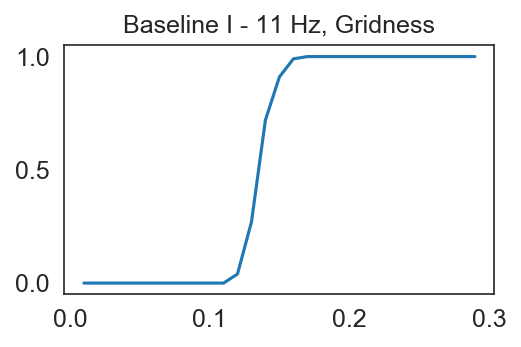

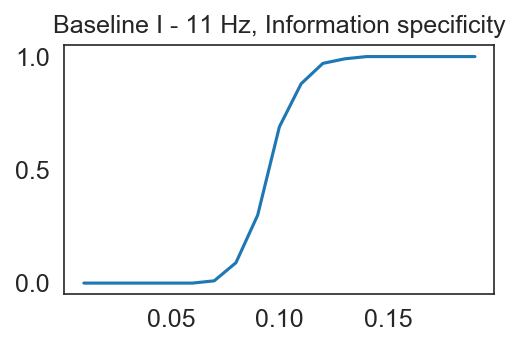

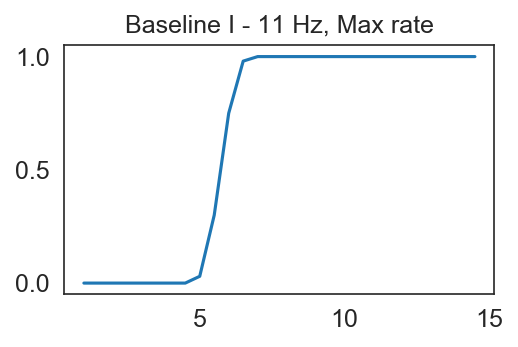

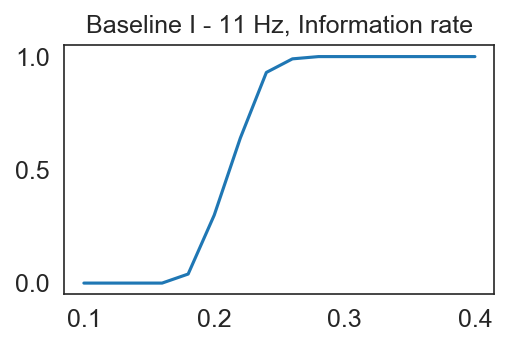

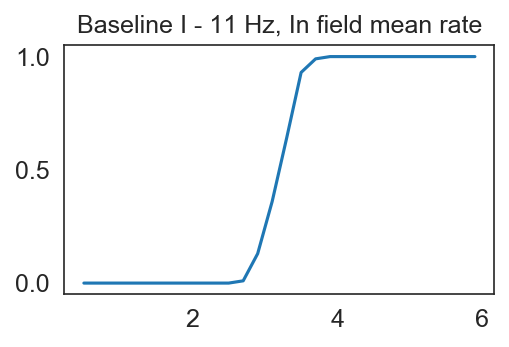

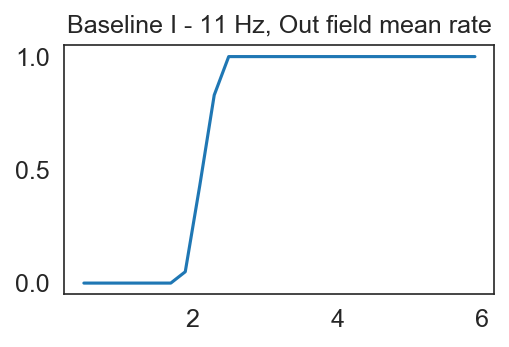

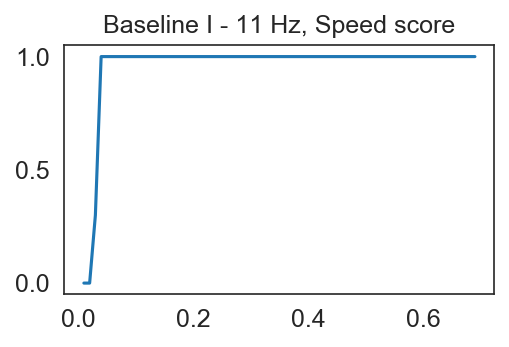

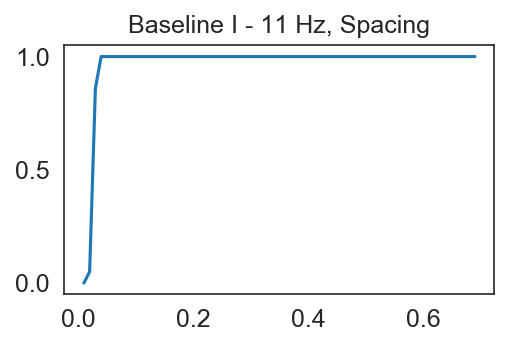

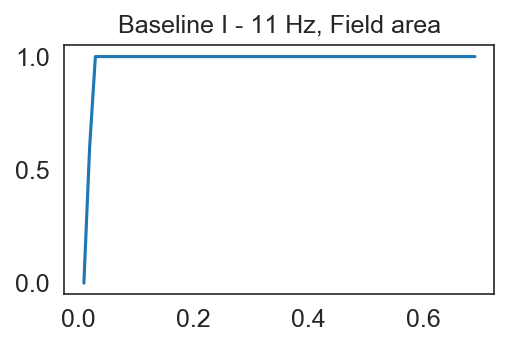

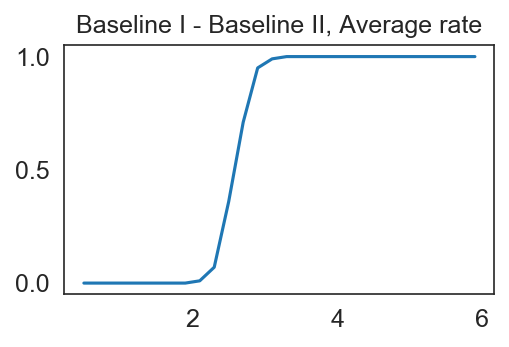

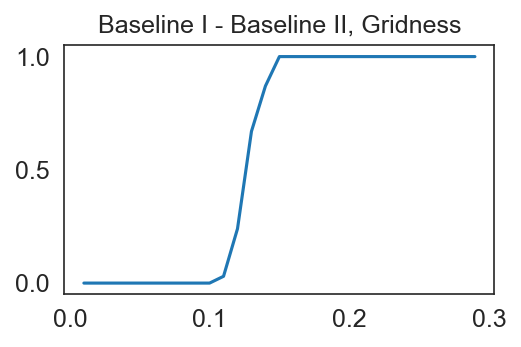

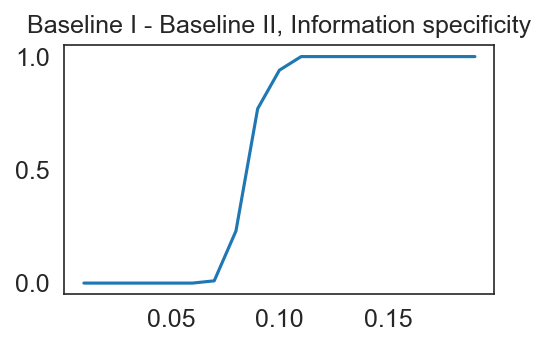

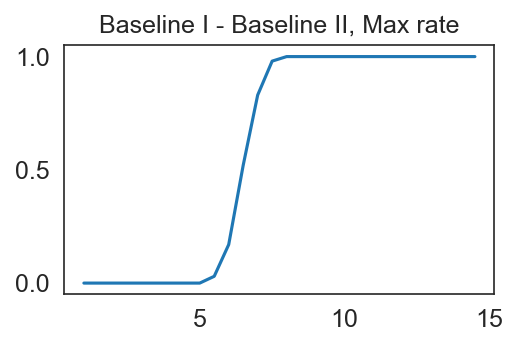

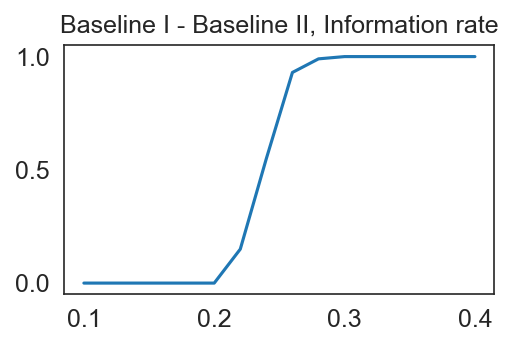

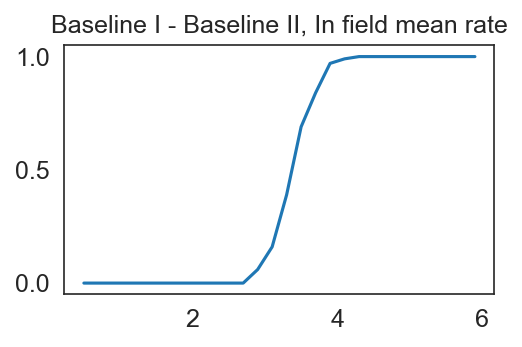

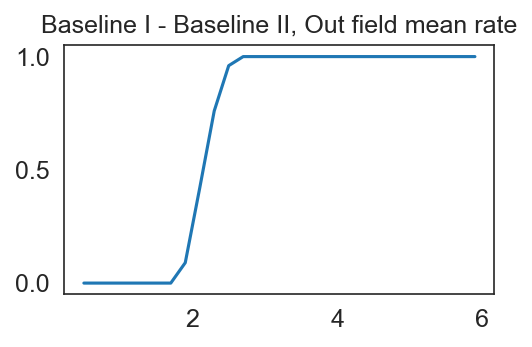

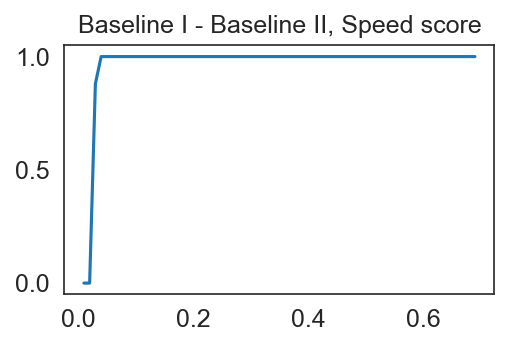

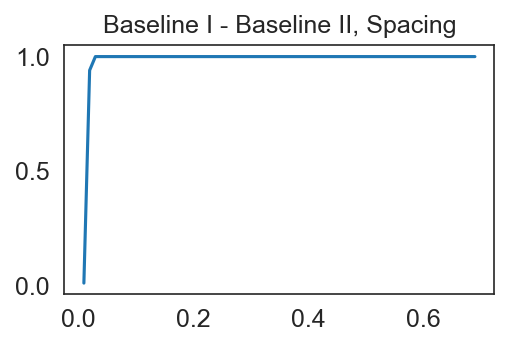

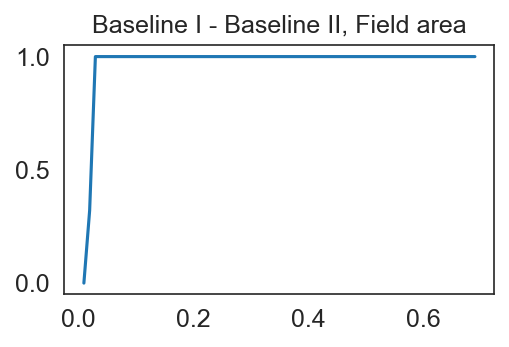

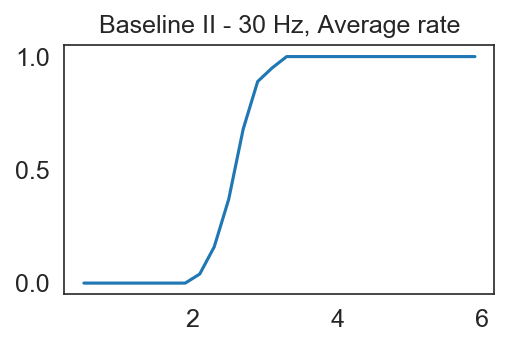

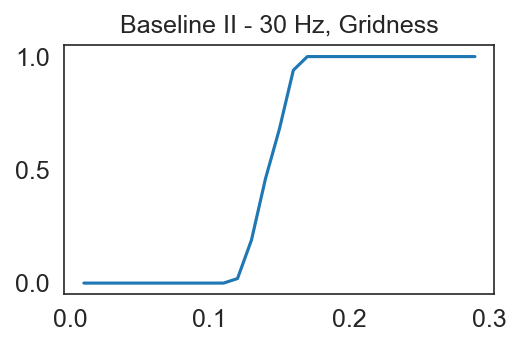

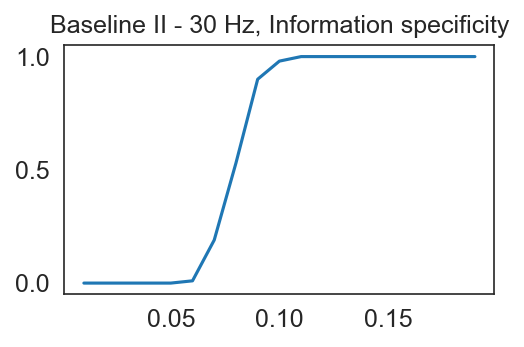

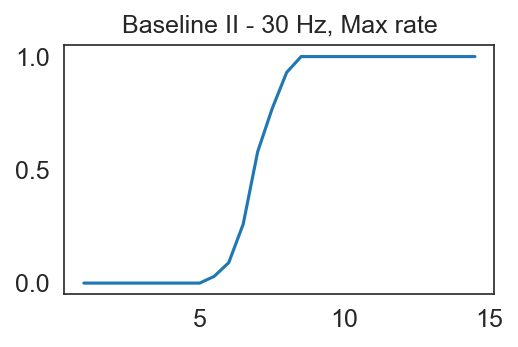

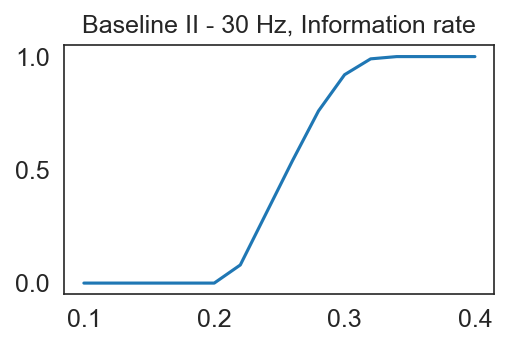

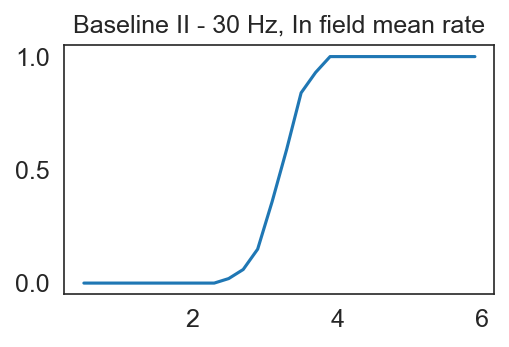

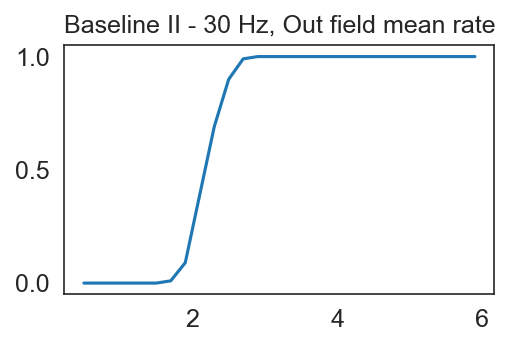

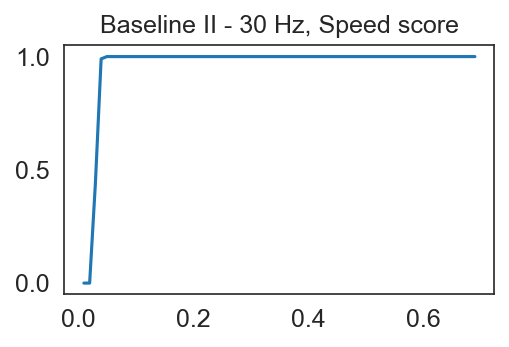

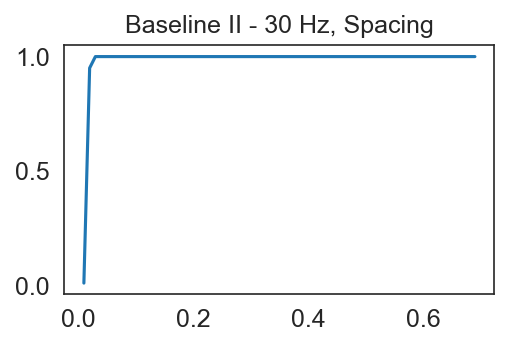

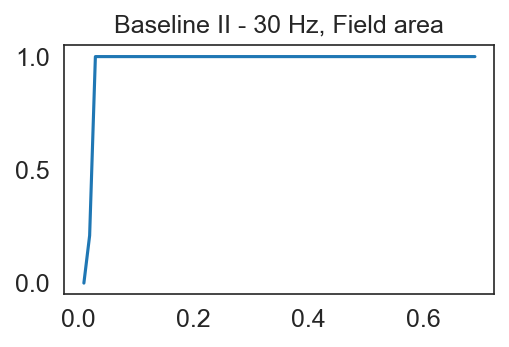

In [146]:
for vs, vals in powers.items():
    for key, val in vals.items():
        plt.figure()
        plt.plot(val['e'], val['p'])
        plt.title(' - '.join(vs) + ', ' + key.replace('_', ' ').capitalize())
        savefig(output_path / 'figures' / f"{'-'.join(vs)}_{key}")

# Store data

In [135]:
np.savez(output_path / 'data' / 'powers.npz', powers)

# Create nice table

In [14]:
from scipy.interpolate import interp1d

In [143]:
effect_size_power_80p = pd.DataFrame()
for vs, vals in powers.items():
    for key, val in vals.items():
        e = interp1d(val['p'], val['e'])(0.8)
        effect_size_power_80p.loc[key.replace('_', ' ').capitalize(), ' - '.join(vs)] = e

In [144]:
effect_size_power_80p

Baseline I - 11 Hz  Baseline I - Baseline II  \
Average rate                       2.669697                  2.775000   
Gridness                           0.144211                  0.136500   
Information specificity            0.105789                  0.091765   
Max rate                           6.108696                  6.951613   
Information rate                   0.231034                  0.253158   
In field mean rate                 3.410345                  3.646667   
Out field mean rate                2.285000                  2.340000   
Speed score                        0.365714                  0.029091   
Spacing                            0.029259                  0.018495   
Field area                         0.260000                  0.358824   

                         Baseline II - 30 Hz  
Average rate                        2.814286  
Gridness                            0.154615  
Information specificity             0.087297  
Max rate                            7.593750  
Information rate                    0.285000  
In field mean rate                  3.468000  
Out field mean rate                 2.404762  
Speed score                         0.036545  
Spacing                             0.018404  
Field area                          0.378481

In [147]:
effect_size_power_80p.to_latex(output_path / "statistics" / "effect_size_power_80p.tex")
effect_size_power_80p.to_csv(output_path / "statistics" / "effect_size_power_80p.csv")

# Estimate required sample size to detect effect size of 0.1 

In [8]:
effect_sizes = {
    'gridness': .1,
    'average_rate': 1, 
    'information_specificity': 0.1,
    'max_rate': 5, 
    'information_rate': 0.2, 
    'in_field_mean_rate': 3, 
    'out_field_mean_rate': 2, 
    'speed_score': 0.1,
    'spacing': 0.05,
    'field_area': 0.05
}

n_samples_ranges = {
    'gridness': (10, 300, 10),
    'average_rate': (10, 300, 10), 
    'information_specificity': (10, 120, 10),
    'max_rate': (10, 120, 10), 
    'information_rate': (10, 120, 10), 
    'in_field_mean_rate': (10, 120, 10), 
    'out_field_mean_rate': (10, 120, 10), 
    'speed_score': (5, 60, 5),
    'spacing': (5, 60, 5),
    'field_area': (5, 60, 5)
}

In [11]:
powers_sample_size = {}
for vs in vss:
    powers_sample_size[vs] = {}
    for key, df in tqdm(results['gridcell'].items(), desc=' - '.join(vs)):
        power, sample_size, effective_sample_size = estimate_sample_size_lmm(
            results['gridcell'][key], *vs, effect_size=effect_sizes[key], n_samples_range=n_samples_ranges[key], key=key)
        powers_sample_size[vs][key] = {'p': power, 's': sample_size, 'es': effective_sample_size}

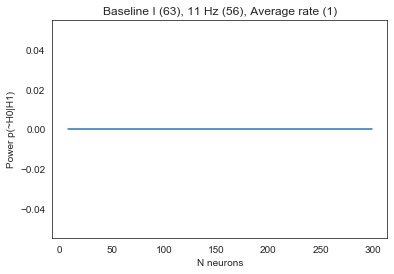

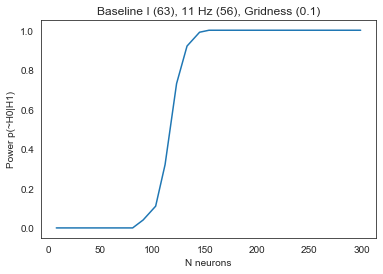

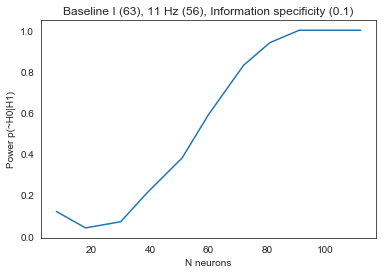

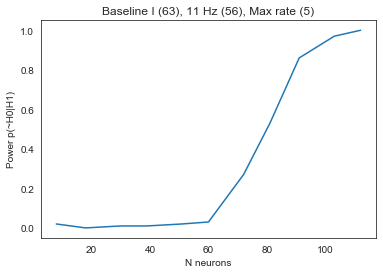

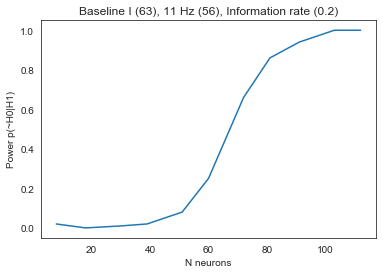

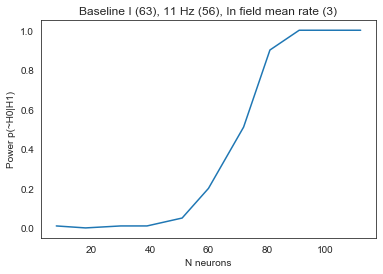

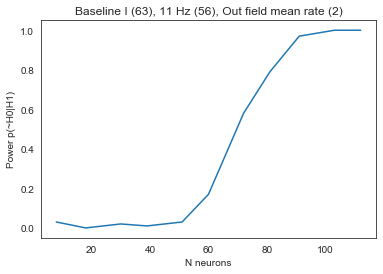

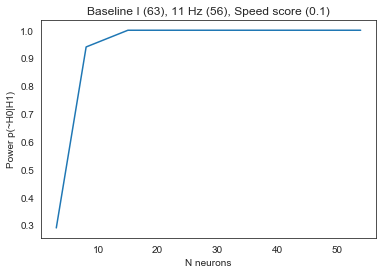

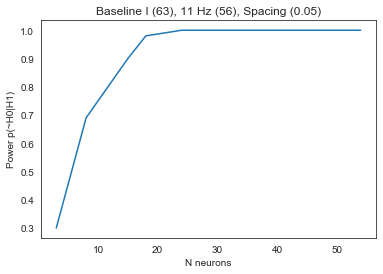

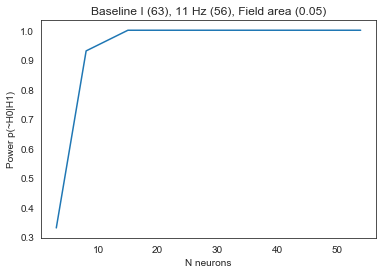

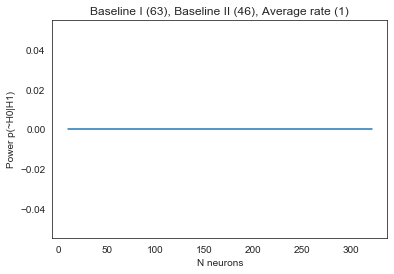

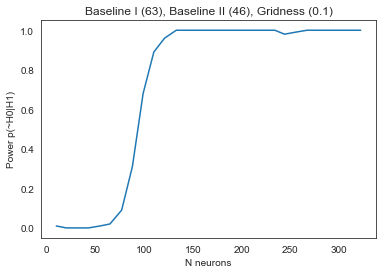

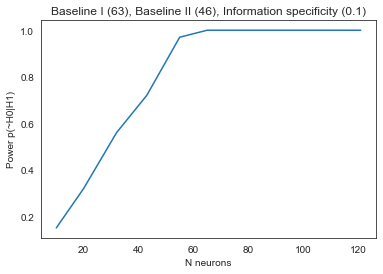

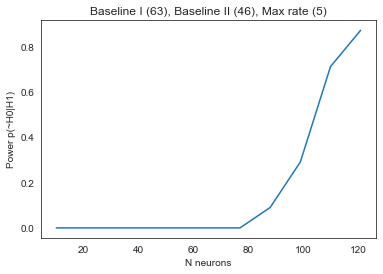

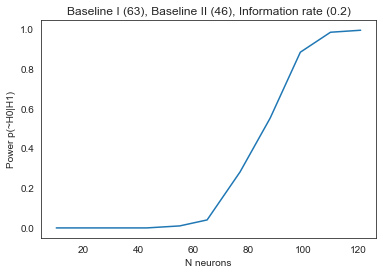

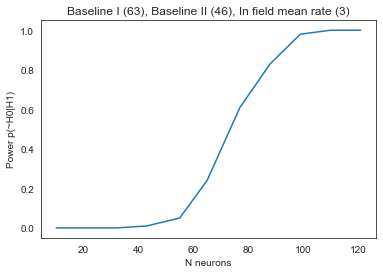

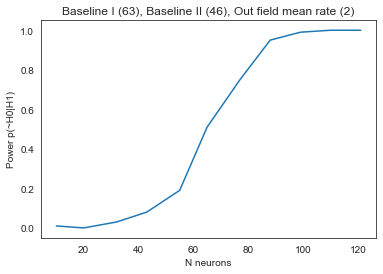

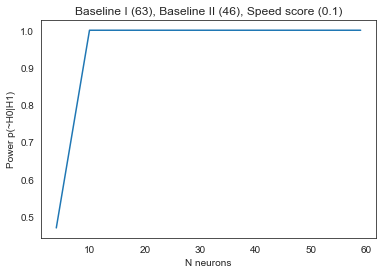

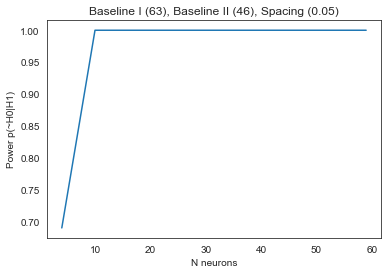

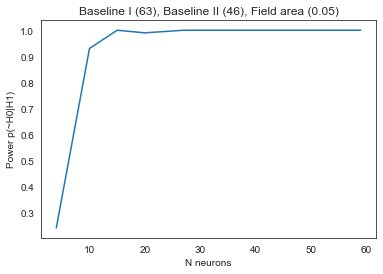

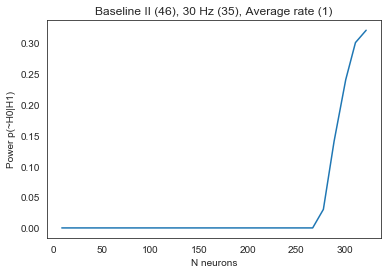

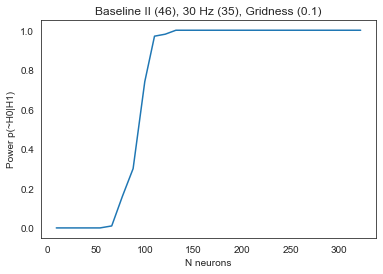

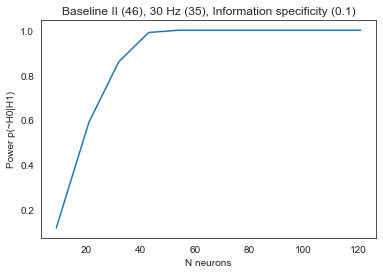

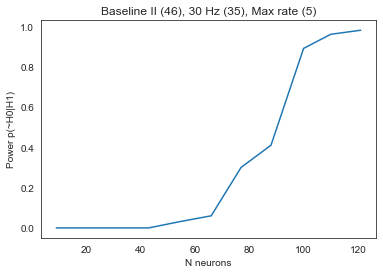

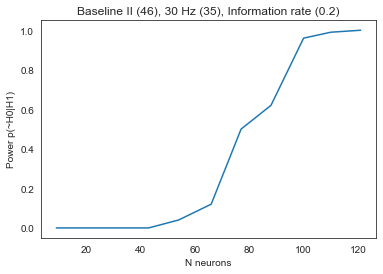

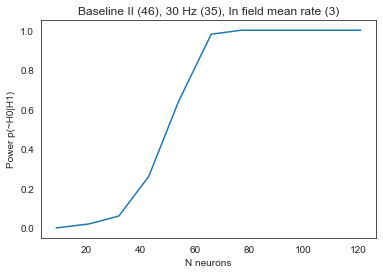

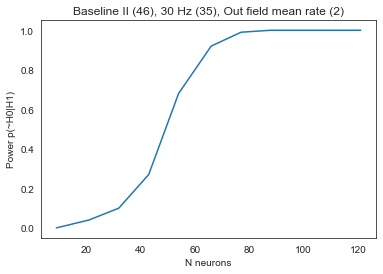

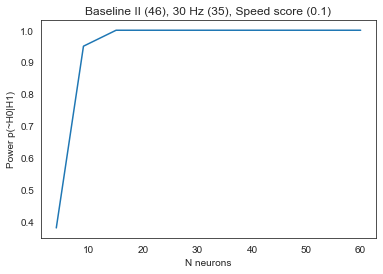

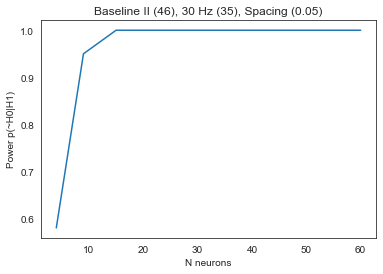

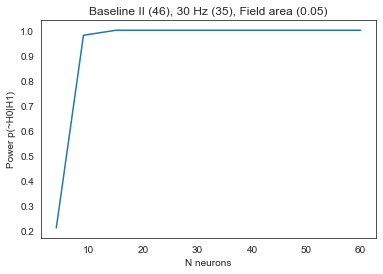

In [12]:
for vs, vals in powers_sample_size.items():
    for key, val in vals.items():
        plt.figure()
        plt.plot(val['es'], val['p'])
        try:
            e = interp1d(val['p'], val['es'])(0.8)
            plt.axvline(e, label=f'N={e:.0f}', color='k')
            plt.axhline(0.8, color='k', alpha=0.1)
            plt.legend()
        except:
            pass
        n1, n2 = results['gridcell'][key][list(vs)].count().values
        plt.title(f"{vs[0]} ({n1}), {vs[1]} ({n2}), {key.replace('_', ' ').capitalize()} ({effect_sizes[key]})")
        plt.ylabel('Power p(~H0|H1)')
        plt.xlabel('N neurons')
        savefig(output_path / 'figures' / f"sample_size_{'-'.join(vs)}_{key}")

In [13]:
sample_size_power_80p = pd.DataFrame()
for vs, vals in powers_sample_size.items():
    for key, val in vals.items():
        e = interp1d(val['p'], val['es'])(0.8)
        name = f"{key.replace('_', ' ').capitalize()}"
        sample_size_power_80p.loc[name, ' - '.join(vs)] = e

NameError: name 'interp1d' is not defined

In [ ]:
sample_size_power_80p

# Store data

In [ ]:
sample_size_power_80p.to_latex(output_path / "statistics" / f"sample_size_power.tex")
sample_size_power_80p.to_csv(output_path / "statistics" / f"sample_size_power.csv")

In [ ]:
np.savez(output_path / 'data' / 'powers_sample_size.npz', powers_sample_size)

# Register in Expipe

In [148]:
action = project.require_action("comparisons-power")

In [149]:
copy_tree(output_path, str(action.data_path()))

['/media/storage/expipe/septum-mec/actions/comparisons-power/data/statistics/effect_size_power_80p.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-power/data/statistics/effect_size_power_80p.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-power/data/data/powers.npz',
 '/media/storage/expipe/septum-mec/actions/comparisons-power/data/figures/Baseline I-11 Hz_field_area.png',
 '/media/storage/expipe/septum-mec/actions/comparisons-power/data/figures/Baseline I-Baseline II_in_field_mean_rate.svg',
 '/media/storage/expipe/septum-mec/actions/comparisons-power/data/figures/Baseline I-Baseline II_gridness.svg',
 '/media/storage/expipe/septum-mec/actions/comparisons-power/data/figures/Baseline I-11 Hz_field_area.svg',
 '/media/storage/expipe/septum-mec/actions/comparisons-power/data/figures/Baseline II-30 Hz_spacing.png',
 '/media/storage/expipe/septum-mec/actions/comparisons-power/data/figures/Baseline I-Baseline II_information_rate.png',
 '/media/storage/expipe/septum

In [150]:
septum_mec.analysis.registration.store_notebook(action, "20_comparisons_power.ipynb")

# Testing

In [213]:
vs, key = vss[0], 'gridness'

In [ ]:
power, sample_size, effective_sample_size = estimate_sample_size_lmm(
    results['gridcell'][key], *vs, effect_size=effect_sizes[key], n_samples_range=(10, 300, 10), key=key)

In [216]:
power, sample_size, effective_sample_size =estimate_sample_size_lmm(
    results['gridcell'][key], *vs, effect_size=effect_sizes[key], n_samples_range=(10, 200, 10), n_repeats=100, key=key)

In [198]:
%%time
power, sample_size, effective_sample_size = estimate_sample_size_lmm_paralell(
    results['gridcell'][key], *vs, effect_size=effect_sizes[key], n_samples_range=(10, 130, 10), n_repeats=100, key=key)

CPU times: user 992 ms, sys: 740 ms, total: 1.73 s
Wall time: 7min 45s


Text(0.5, 0, 'N neurons')

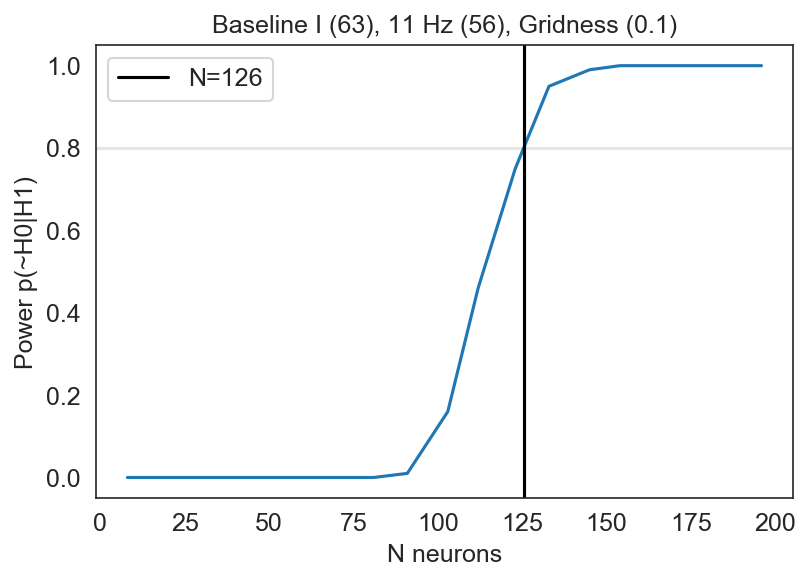

In [226]:
plt.plot(effective_sample_size, power)
estimated_sample_size = interp1d(power, effective_sample_size)(0.8)
plt.axvline(estimated_sample_size, label=f'N={estimated_sample_size:.0f}', color='k')
plt.axhline(0.8, color='k', alpha=0.1)
n1, n2 = results['gridcell'][key][list(vs)].count().values
plt.title(f"{vs[0]} ({n1}), {vs[1]} ({n2}), {key.replace('_', ' ').capitalize()} ({effect_sizes[key]})")
plt.legend()
plt.ylabel('Power p(~H0|H1)')
plt.xlabel('N neurons')
# plt.xlim(0,200)